In [13]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from src.preprocessamento import preprocess_data
from src.utils import generate_neighbors
from src.algoritmos import *
from src.vizualizacao import plot_kmeans_results
from src.tabu import *
from tabulate import tabulate

NUM_PASSOS = 2

#-------------------

In [14]:
#----------------------------------------------------------
# Função para carregar dados
def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = [
        'Class', 'Alcohol', 'Malic_Acid', 'Ash', 'Alcalinity_of_Ash',
        'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
        'Proanthocyanins', 'Color_Intensity', 'Hue',
        'OD280/OD315_of_Diluted_Wines', 'Proline'
    ]
    return data

#----------------------------------------------------------
# Função para executar o K-Means
def execute_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    print("Centroides encontrados pelo K-Means:", kmeans.centroids)
    return kmeans

#----------------------------------------------------------
# Função para plotar resultados
def plot_results(reduced_data, kmeans, centroids_best, history_first, history_best):
    plot_kmeans_results(reduced_data, kmeans.centroids, kmeans.labels)

    plt.scatter(centroids_best[:, 0], centroids_best[:, 1], c='red', marker='X', label='Busca Local (Melhor Melhora)')
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='blue', marker='o', label='K-Means')
    plt.xlabel("Flavanoids")
    plt.ylabel("Total_Phenols")
    plt.title("Comparação de Centróides: K-Means vs. Busca Local (Melhor Melhora) ")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(history_first, label="Primeira Melhora", marker="o")
    plt.plot(history_best, label="Melhor Melhora", marker="s", linestyle="--", linewidth=0.8)
    plt.xlabel("Iteração")
    plt.ylabel("Custo")
    plt.title("Histórico de Custos: Busca Local com {} Passos".format(NUM_PASSOS))
    plt.legend()
    plt.grid(True)
    plt.show()

#----------------------------------------------------------
# Função de plotagem
def plot_cost_histories(histories):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    for label, history in histories.items():
        plt.plot(history, label=label, marker="o")
    plt.xlabel("Iteração")
    plt.ylabel("Custo")
    plt.title(f"Histórico de Custos de Todos os Métodos com {NUM_PASSOS} Passos")
    plt.legend()
    plt.grid(True)
    plt.show()


#----------------------------------------------------------
# Função para imprimir separador visual
def print_separator():
    print("-" * 60)

#----------------------------------------------------------
# Função para exibir a tabela de resultados
def mostrar_tabela_resultados(resultados):
    headers = ["Metodo", "Centroides Encontrados", "Custo Total", "Histórico de Custos"]
    resultados_formatados = [
        [metodo, centroides, custo, len(hist)] for metodo, centroides, custo, hist in resultados
    ]
    print(tabulate(resultados_formatados, headers=headers, tablefmt="grid"))

#----------------------------------------------------------

Centroides encontrados pelo K-Means: [[ 0.23242425  0.16964401]
 [-1.00234577 -0.99855091]
 [ 1.11694924  1.17118187]]
Custo total do K-Means: 93.35342521850802
------------------------------------------------------------
Vizinhanças geradas:
[[[ 0.03242425  0.36964401]
  [ 0.33242425  0.36964401]
  [ 0.43242425 -0.03035599]
  [ 0.13242425 -0.03035599]
  [ 0.23242425  0.06964401]
  [ 0.33242425  0.26964401]
  [ 0.03242425  0.26964401]
  [ 0.43242425  0.36964401]
  [ 0.13242425  0.36964401]
  [ 0.23242425 -0.03035599]
  [ 0.03242425  0.16964401]
  [ 0.33242425  0.16964401]
  [ 0.43242425  0.26964401]
  [ 0.13242425  0.26964401]
  [ 0.23242425  0.36964401]
  [ 0.03242425  0.06964401]
  [ 0.33242425  0.06964401]
  [ 0.43242425  0.16964401]
  [ 0.13242425  0.16964401]
  [ 0.03242425 -0.03035599]
  [ 0.23242425  0.26964401]
  [ 0.33242425 -0.03035599]
  [ 0.43242425  0.06964401]
  [ 0.13242425  0.06964401]]

 [[-0.80234577 -0.99855091]
  [-1.20234577 -0.99855091]
  [-0.90234577 -1.09855091]

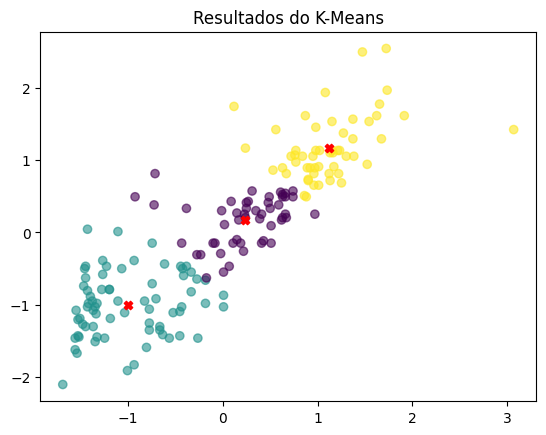

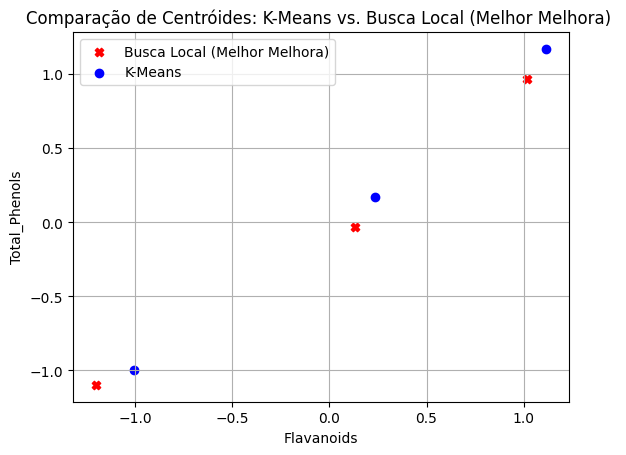

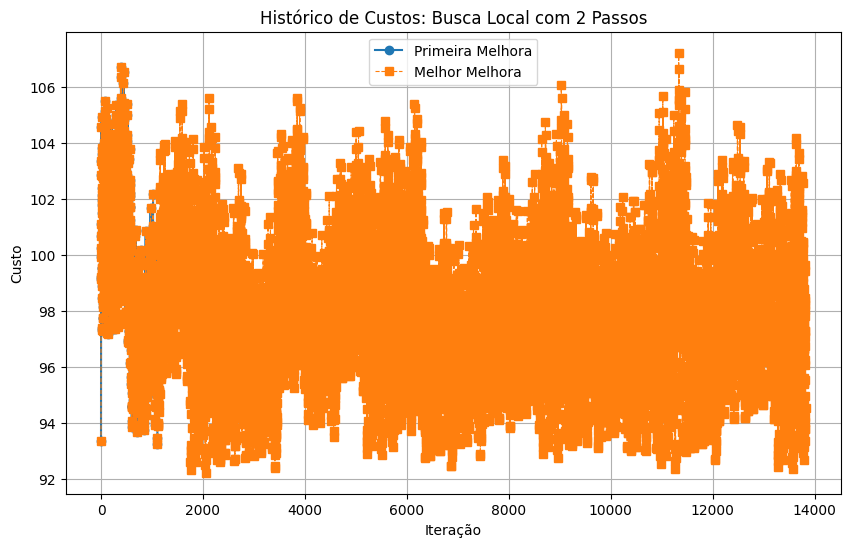

Melhores centróides pela busca tabu: [[ 0.13242425 -0.03035599]
 [-1.20234577 -1.09855091]
 [ 1.01694924  0.97118187]]
Custo final da busca tabu: 92.22739845084902
------------------------------------------------------------


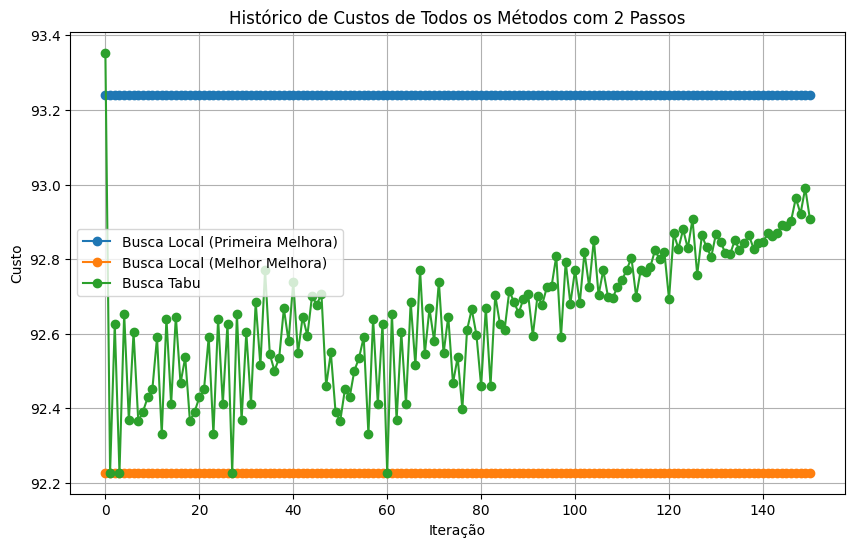


## RESUMO DOS RESULTADOS ##

+--------------------------------+-------------------------------------------------------------------------------------------+---------------+-----------------------+
| Metodo                         | Centroides Encontrados                                                                    |   Custo Total |   Histórico de Custos |
+================================+===========================================================================================+===============+=======================+
| K-Means                        | [[0.23242425, 0.16964401], [-1.00234577, -0.99855091], [1.11694924, 1.17118187]]          |       93.3534 |                     0 |
+--------------------------------+-------------------------------------------------------------------------------------------+---------------+-----------------------+
| Busca Local (Primeira Melhora) | [[0.33242425, 0.36964401], [-1.1023457700000001, -0.99855091], [1.11694924, 1.07118187]]  |       93

In [15]:

    """
    Função principal para executar o pipeline completo, incluindo o K-Means,
    busca local (primeira e melhor melhora) e busca tabu.
    """
    # Resultados armazenados para a tabela
    resultados = []
   

    # Carregar e preparar os dados
    data = load_data("data/wine.data")
    features = ['Flavanoids', 'Total_Phenols']
    reduced_data, scaler = preprocess_data(data, features)

    # Executar K-Means
    kmeans = execute_kmeans(reduced_data, n_clusters=3)

    resultados.append(["K-Means", kmeans.centroids.tolist(), kmeans.cost(), []])
    print("Custo total do K-Means:", kmeans.cost())
    print_separator()

    # Gerar vizinhanças dos centróides
    neighbors = generate_neighbors(kmeans.centroids, delta=0.1, N_PASSOS=NUM_PASSOS)

    print("Vizinhanças geradas:")
    print(neighbors)
    
    # Busca local (primeira melhora)
    neighbors_local = neighbors.copy()
    # random.shuffle(neighbors_local)

    first_centroids, first_distance, history_first = local_search(reduced_data, kmeans.centroids, neighbors_local, mode="first")

    resultados.append(["Busca Local (Primeira Melhora)", first_centroids.tolist(), first_distance, history_first])
    print("Primeiros centróides encontrados:", first_centroids)
    print("Custo total da busca local (primeira melhora):", first_distance)
    print_separator()

    # Busca local (melhor melhora)
    best_centroids, best_distance, history_best = local_search(reduced_data, kmeans.centroids, neighbors_local, mode="best")

    resultados.append(["Busca Local (Melhor Melhora)", best_centroids.tolist(), best_distance, history_best])
    print("Melhores centróides encontrados:", best_centroids)
    print("Custo total da busca local (melhor melhora):", best_distance)
    print_separator()

    # Visualizar resultados
    plot_results(reduced_data, kmeans, best_centroids, history_first, history_best)

    # Busca tabu
    neighbors_tabu = neighbors.copy()
    best_centroids_tabu, best_cost_tabu, history_tabu = tabu_search( reduced_data, kmeans.centroids, neighbors_tabu, max_iter=150, tabu_size=150 )
    
    resultados.append(["Busca Tabu", best_centroids_tabu.tolist(), best_cost_tabu, history_tabu])
    print("Melhores centróides pela busca tabu:", best_centroids_tabu)
    print("Custo final da busca tabu:", best_cost_tabu)
    print_separator()

    # Plotar históricos de custo de todos os métodos
    # Obter os valores mínimos
    min_first = min(history_first)
    min_best = min(history_best)
    # Criar as retas horizontais com base no tamanho do histórico da busca tabu
    horizontal_first = [min_first] * len(history_tabu)
    horizontal_best = [min_best] * len(history_tabu)
    plot_cost_histories({
        "Busca Local (Primeira Melhora)": horizontal_first,
        "Busca Local (Melhor Melhora)": horizontal_best,
        "Busca Tabu": history_tabu
    })


    # Exibir tabela de resultados
    print("\n## RESUMO DOS RESULTADOS ##\n")
    mostrar_tabela_resultados(resultados)
    # Execução do programa
